In [2]:
# دانلود و استخراج فایل Yelp-JSON و نمایش حجم فایل‌ها

import requests

url = "https://business.yelp.com/external-assets/files/Yelp-JSON.zip"
filename = "Yelp-JSON.zip"

# Adding a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, stream=True, headers=headers)
response.raise_for_status()  # Raise an exception for HTTP errors

with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded {filename} successfully.")

Downloaded Yelp-JSON.zip successfully.


In [3]:
# استخراج فایل Zip و Tar و نمایش حجم پوشه‌ها/فایل‌ها

!unzip -o Yelp-JSON.zip
print("Extracted Yelp-JSON.zip successfully.")

!tar -xf "Yelp JSON/yelp_dataset.tar" -C .

!du -sh *

Archive:  Yelp-JSON.zip
   creating: Yelp JSON/
  inflating: Yelp JSON/Yelp Dataset Documentation & ToS copy.pdf  
  inflating: __MACOSX/Yelp JSON/._Yelp Dataset Documentation & ToS copy.pdf  
  inflating: Yelp JSON/yelp_dataset.tar  
  inflating: __MACOSX/Yelp JSON/._yelp_dataset.tar  
Extracted Yelp-JSON.zip successfully.
80K	Dataset_User_Agreement.pdf
16K	__MACOSX
55M	sample_data
114M	yelp_academic_dataset_business.json
274M	yelp_academic_dataset_checkin.json
5.0G	yelp_academic_dataset_review.json
173M	yelp_academic_dataset_tip.json
3.2G	yelp_academic_dataset_user.json
4.1G	Yelp JSON
4.1G	Yelp-JSON.zip


In [5]:
# Cell 3: Sample data and create df_business_sampled, df_review_sampled, df_user_sampled

import pandas as pd
import os
import random
import io

# Paths to JSON files (now in current directory)
business_file = 'yelp_academic_dataset_business.json'
review_file = 'yelp_academic_dataset_review.json'
user_file = 'yelp_academic_dataset_user.json'

# Sampling rates
sample_rate_business = 0.50  # 50% for business file
sample_rate_large = 0.10     # 10% for review and user files

# --- Sample and load business file ---
print(f"Re-sampling and loading {business_file} with rate {sample_rate_business*100}%...")
sampled_business_lines = []
with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_business:
            sampled_business_lines.append(line)
df_business_sampled = pd.read_json(io.StringIO(''.join(sampled_business_lines)), lines=True)
print("df_business_sampled shape:", df_business_sampled.shape)

# --- Sample and load review file ---
print(f"Re-sampling and loading {review_file} with rate {sample_rate_large*100}%...")
sampled_review_lines = []
with open(review_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_large:
            sampled_review_lines.append(line)
df_review_sampled = pd.read_json(io.StringIO(''.join(sampled_review_lines)), lines=True)
print("df_review_sampled shape:", df_review_sampled.shape)

# --- Sample and load user file ---
print(f"Re-sampling and loading {user_file} with rate {sample_rate_large*100}%...")
sampled_user_lines = []
with open(user_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_large:
            sampled_user_lines.append(line)
df_user_sampled = pd.read_json(io.StringIO(''.join(sampled_user_lines)), lines=True)
print("df_user_sampled shape:", df_user_sampled.shape)

print("Sampled Yelp dataset files re-loaded into DataFrames successfully.")

Re-sampling and loading yelp_academic_dataset_business.json with rate 50.0%...
df_business_sampled shape: (75338, 14)
Re-sampling and loading yelp_academic_dataset_review.json with rate 10.0%...
df_review_sampled shape: (698749, 9)
Re-sampling and loading yelp_academic_dataset_user.json with rate 10.0%...
df_user_sampled shape: (198597, 22)
Sampled Yelp dataset files re-loaded into DataFrames successfully.


In [7]:
S# Cell 4: Use sampled data as main dataframes + imports for plotting

import matplotlib.pyplot as plt
import seaborn as sns

df_review = df_review_sampled
df_business = df_business_sampled
df_user = df_user_sampled

sns.set_style("whitegrid")
print("DataFrames and plotting libraries are ready.")

DataFrames and plotting libraries are ready.


# Scenario 1

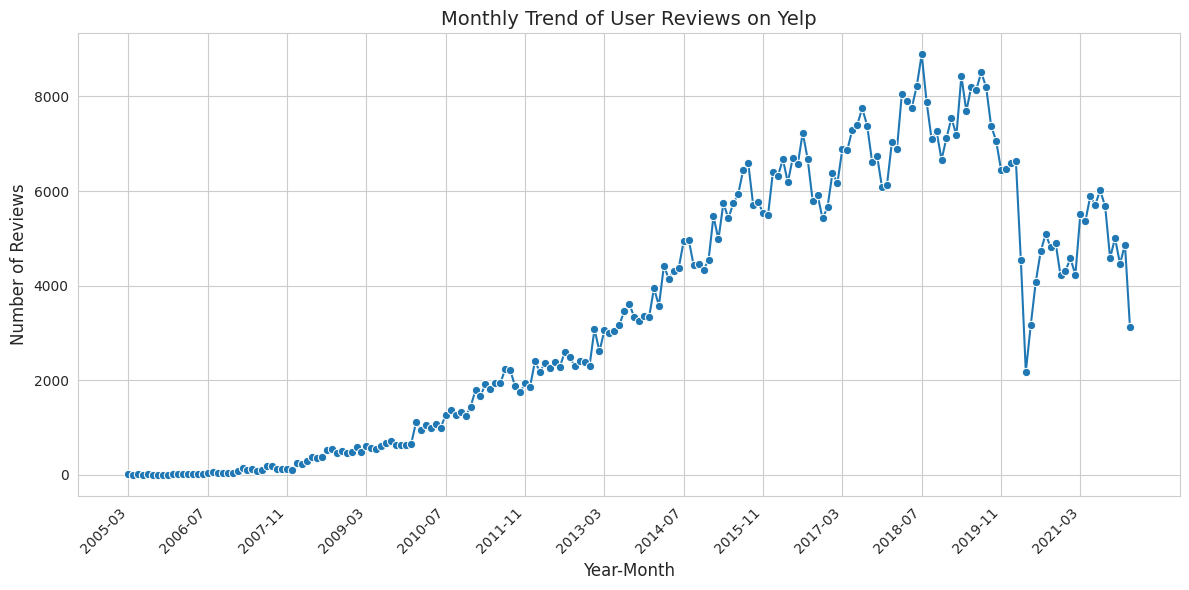

In [8]:
# Scenario 1: Line Chart - Trend of User Activity (Number of Reviews per Month)

# 1. Ensure 'date' is in datetime format
df_review['date'] = pd.to_datetime(df_review['date'])

# 2. Create a Year-Month column for monthly grouping
df_review['year_month'] = df_review['date'].dt.to_period('M').astype(str)

# 3. Group by Year-Month and count the number of reviews in each month
monthly_reviews = (
    df_review
    .groupby('year_month')
    .size()
    .reset_index(name='review_count')
    .sort_values('year_month')
)

# 4. Plot the monthly trend using a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_reviews,
    x='year_month',
    y='review_count',
    marker='o',
    color='tab:blue'
)

plt.title('Monthly Trend of User Reviews on Yelp', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Make x-axis more readable (fewer ticks, rotated labels)
tick_step = max(1, len(monthly_reviews) // 12)
plt.xticks(
    ticks=range(0, len(monthly_reviews), tick_step),
    labels=monthly_reviews['year_month'].iloc[::tick_step],
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()

# Scenario 2

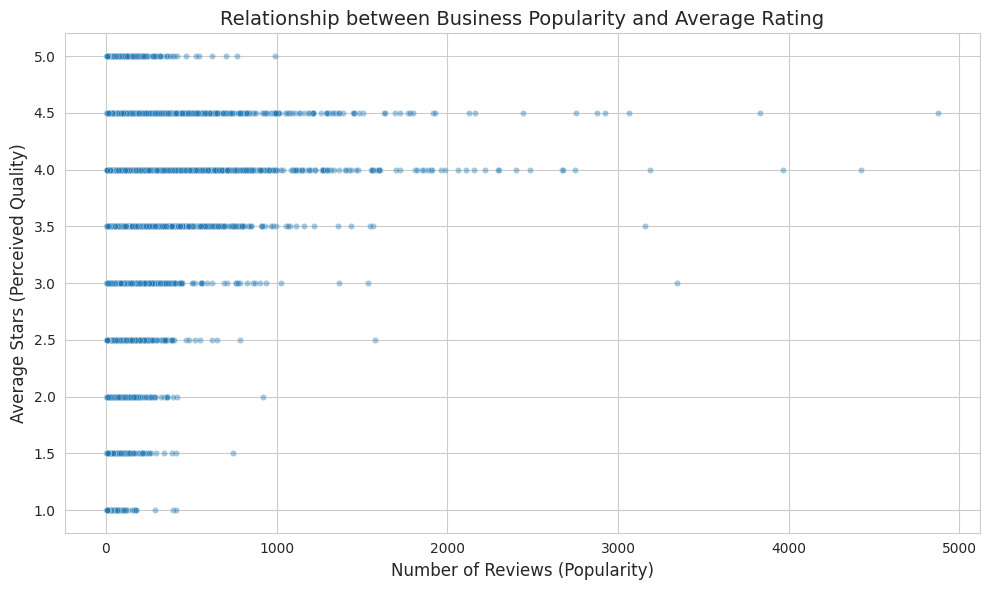

In [9]:
# Scenario 2: Scatter Plot - Relationship between Popularity and Perceived Quality
# For each business: x = review_count (popularity), y = stars (average rating / quality)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select needed columns and drop rows with missing values
business_pop_quality = (
    df_business[['review_count', 'stars']]
    .dropna(subset=['review_count', 'stars'])
)

# (Optional) Remove extreme outliers in review_count for clearer visualization
# For example, keep businesses with review_count <= 5000
business_pop_quality = business_pop_quality[business_pop_quality['review_count'] <= 5000]

# 2. Plot scatter plot: review_count vs stars
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=business_pop_quality,
    x='review_count',
    y='stars',
    alpha=0.4,
    s=20,
    color='tab:blue'
)

plt.title('Relationship between Business Popularity and Average Rating', fontsize=14)
plt.xlabel('Number of Reviews (Popularity)', fontsize=12)
plt.ylabel('Average Stars (Perceived Quality)', fontsize=12)

plt.tight_layout()
plt.show()

# Scenario 3

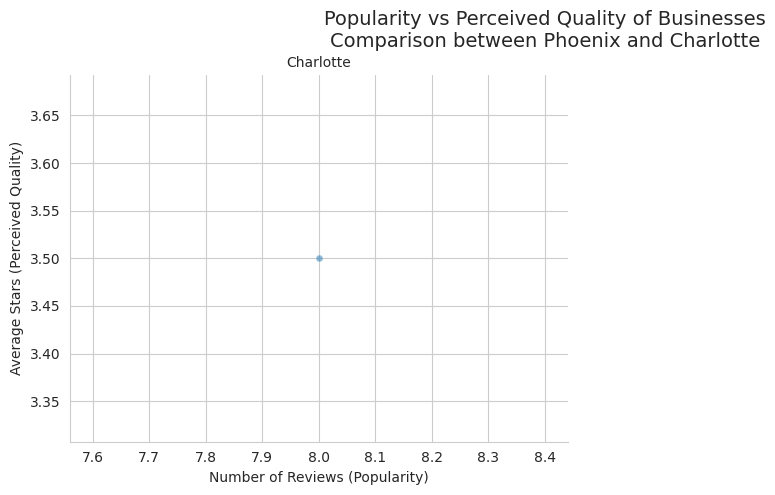

In [10]:
# Scenario 3: Rel Plot - Comparing Relationship between Two Cities
# Compare popularity (review_count) vs quality (stars) for businesses in Phoenix and Charlotte

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter for two major cities: Phoenix and Charlotte
cities_of_interest = ['Phoenix', 'Charlotte']

# Keep only rows with non-missing city, review_count, and stars
df_business_cities = df_business[
    df_business['city'].isin(cities_of_interest)
].dropna(subset=['review_count', 'stars'])

# (Optional) Limit very large review_count values for clearer plots
df_business_cities = df_business_cities[df_business_cities['review_count'] <= 5000]

# 2. Create a relplot with kind="scatter", one subplot per city (col="city")
sns.set_style("whitegrid")

g = sns.relplot(
    data=df_business_cities,
    x='review_count',
    y='stars',
    col='city',
    kind='scatter',
    col_wrap=2,          # put the two cities side-by-side
    height=5,
    aspect=1.1,
    alpha=0.5,
    s=25,
    color='tab:blue'
)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Number of Reviews (Popularity)", "Average Stars (Perceived Quality)")

plt.subplots_adjust(top=0.85)
g.fig.suptitle(
    "Popularity vs Perceived Quality of Businesses\nComparison between Phoenix and Charlotte",
    fontsize=14
)

plt.show()

# Scenario 4

In [12]:
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

Number of restaurant rows with price 1–4: 22254

Average stars and count per price level:
               mean  count
price_num                 
1          3.294139   9742
2          3.584515  11566
3          3.671783    847
4          3.691919     99


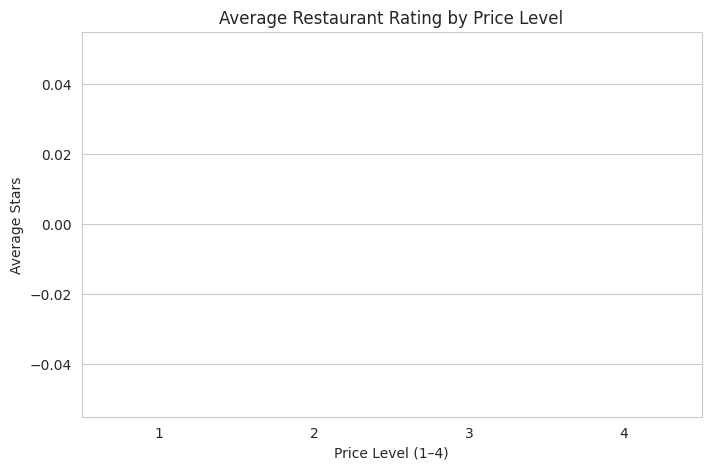

In [23]:
# Scenario 4: Bar Plot - Comparing Quality by Price Level for Restaurants (ultra-minimal)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Filter to restaurant businesses
df_restaurants = df_business.dropna(subset=['categories']).copy()
df_restaurants = df_restaurants[
    df_restaurants['categories'].str.contains('Restaurants', case=False, na=False)
].dropna(subset=['stars'])

# 2. Extract numeric price range from attributes['RestaurantsPriceRange2']
def get_price_range(attrs):
    if not isinstance(attrs, dict):
        return np.nan
    return attrs.get('RestaurantsPriceRange2')

df_restaurants['price_num'] = pd.to_numeric(
    df_restaurants['attributes'].apply(get_price_range),
    errors='coerce'
)

# Keep only rows with price_num in 1–4
df_restaurants = df_restaurants[df_restaurants['price_num'].isin([1, 2, 3, 4])]

print("Number of restaurant rows with price 1–4:", len(df_restaurants))

# 3. Simple aggregated table (good to show in your report too)
summary = (
    df_restaurants
    .groupby('price_num')['stars']
    .agg(['mean', 'count'])
    .reindex([1, 2, 3, 4])
)
print("\nAverage stars and count per price level:")
print(summary)

# 4. Minimal barplot: let seaborn handle ticks and labels, no $ and no manual xticks
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_restaurants,
    x='price_num',
    y='stars',
    order=[1, 2, 3, 4],
    estimator=np.mean,
    errorbar=('sd'),
    color='tab:blue'
)

plt.title('Average Restaurant Rating by Price Level')
plt.xlabel('Price Level (1–4)')
plt.ylabel('Average Stars')

# IMPORTANT: do not call tight_layout (this is where your error happens)
plt.show()

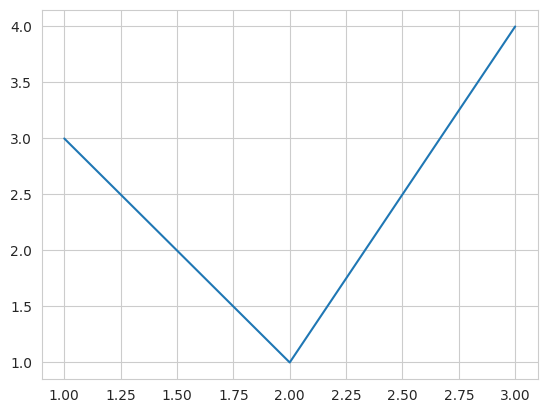

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot([1, 2, 3], [3, 1, 4])
plt.show()

# Scenario 5

Number of reviews with star ratings 1–5: 698749


/tmp/ipython-input-1425875779.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


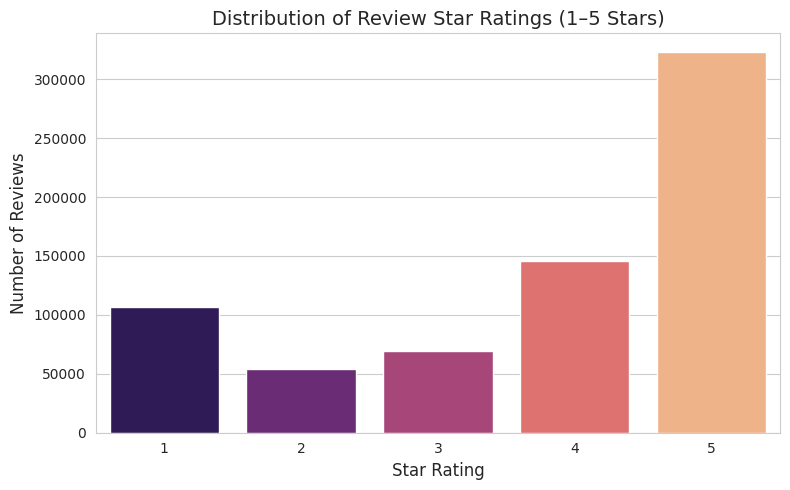

In [20]:
# Scenario 5: Count Plot - Distribution of Review Star Ratings (1 to 5 Stars)

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Keep only valid star ratings (1–5) and drop missing values
df_review_valid = df_review.dropna(subset=['stars'])
df_review_valid = df_review_valid[df_review_valid['stars'].isin([1, 2, 3, 4, 5])]

print("Number of reviews with star ratings 1–5:", len(df_review_valid))

# 2. Plot countplot: x = stars, y = count of reviews
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.countplot(
    data=df_review_valid,
    x='stars',
    order=[1, 2, 3, 4, 5],
    palette='magma'
)

plt.title('Distribution of Review Star Ratings (1–5 Stars)', fontsize=14)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.tight_layout()
plt.show()

# Scenario 6

In [32]:
# DEBUG: check what stars look like in df_cuisine

df_rest = df_business.dropna(subset=['categories']).copy()
df_rest = df_rest[
    df_rest['categories'].str.contains('Restaurants', case=False, na=False)
].dropna(subset=['stars'])

cuisines = ['Italian', 'Mexican', 'Chinese']

def detect_cuisine(categories_str):
    cats_lower = categories_str.lower()
    for c in cuisines:
        if c.lower() in cats_lower:
            return c
    return None

df_rest['cuisine'] = df_rest['categories'].apply(detect_cuisine)

df_cuisine = df_rest[df_rest['cuisine'].isin(cuisines)].copy()

print("df_cuisine shape:", df_cuisine.shape)
print("\n`stars` dtype:", df_cuisine['stars'].dtype)
print("\nFirst 10 unique star values in df_cuisine['stars']:")
print(df_cuisine['stars'].unique()[:10])

print("\nValue counts for stars:")
print(df_cuisine['stars'].value_counts().sort_index())

df_cuisine shape: (6116, 15)

`stars` dtype: float64

First 10 unique star values in df_cuisine['stars']:
[4.  3.  5.  3.5 1.5 4.5 2.5 2.  1. ]

Value counts for stars:
stars
1.0      30
1.5     145
2.0     327
2.5     594
3.0     967
3.5    1559
4.0    1579
4.5     777
5.0     138
Name: count, dtype: int64


Number of rows per cuisine:
cuisine
Mexican    2270
Italian    2265
Chinese    1581
Name: count, dtype: int64

Star value counts (all):
stars
1.0      30
1.5     145
2.0     327
2.5     594
3.0     967
3.5    1559
4.0    1579
4.5     777
5.0     138
Name: count, dtype: int64


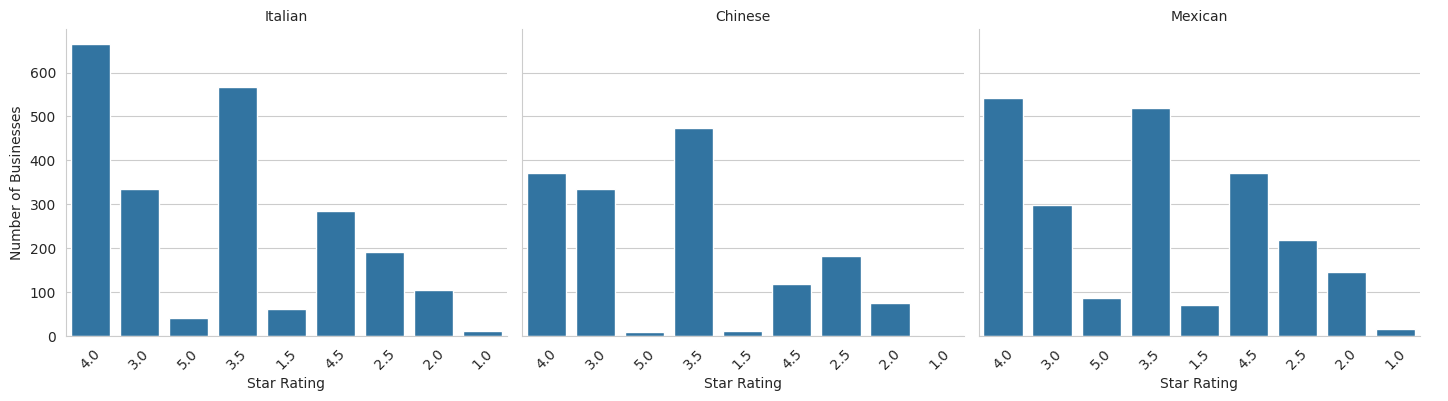

In [33]:
# Scenario 6: Cat Plot - Star Rating Distributions for Italian, Mexican, Chinese

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter to restaurant businesses
df_rest = df_business.dropna(subset=['categories']).copy()
df_rest = df_rest[
    df_rest['categories'].str.contains('Restaurants', case=False, na=False)
].dropna(subset=['stars'])

# 2. Define cuisines of interest
cuisines = ['Italian', 'Mexican', 'Chinese']

# 3. Detect cuisine based on categories
def detect_cuisine(categories_str):
    cats_lower = categories_str.lower()
    for c in cuisines:
        if c.lower() in cats_lower:
            return c
    return None

df_rest['cuisine'] = df_rest['categories'].apply(detect_cuisine)

# 4. Keep only selected cuisines
df_cuisine = df_rest[df_rest['cuisine'].isin(cuisines)].copy()

print("Number of rows per cuisine:")
print(df_cuisine['cuisine'].value_counts())

print("\nStar value counts (all):")
print(df_cuisine['stars'].value_counts().sort_index())

if df_cuisine.empty:
    print("No data for the selected cuisines.")
else:
    sns.set_style("whitegrid")

    # Convert stars to string categories so Seaborn treats them as discrete
    df_cuisine['stars_cat'] = df_cuisine['stars'].astype(str)

    g = sns.catplot(
        data=df_cuisine,
        x='stars_cat',
        col='cuisine',
        kind='count',
        col_wrap=3,
        height=4,
        aspect=1.2
    )

    g.set_axis_labels("Star Rating", "Number of Businesses")
    g.set_titles(col_template="{col_name}")

    # Rotate x labels so they don't overlap
    for ax in g.axes.flat:
        ax.tick_params(axis='x', labelrotation=45)

    # Let seaborn/matplotlib handle layout; no tight_layout() to avoid issues
    plt.show()

# Scenario 7

Number of users: 198597
Basic stats for user review counts:
count    198597.000000
mean         23.233619
std          80.579053
min           0.000000
25%           2.000000
50%           5.000000
75%          16.000000
max        9941.000000
Name: review_count, dtype: float64

Clipping values above the 99th percentile (~313) for visualization.


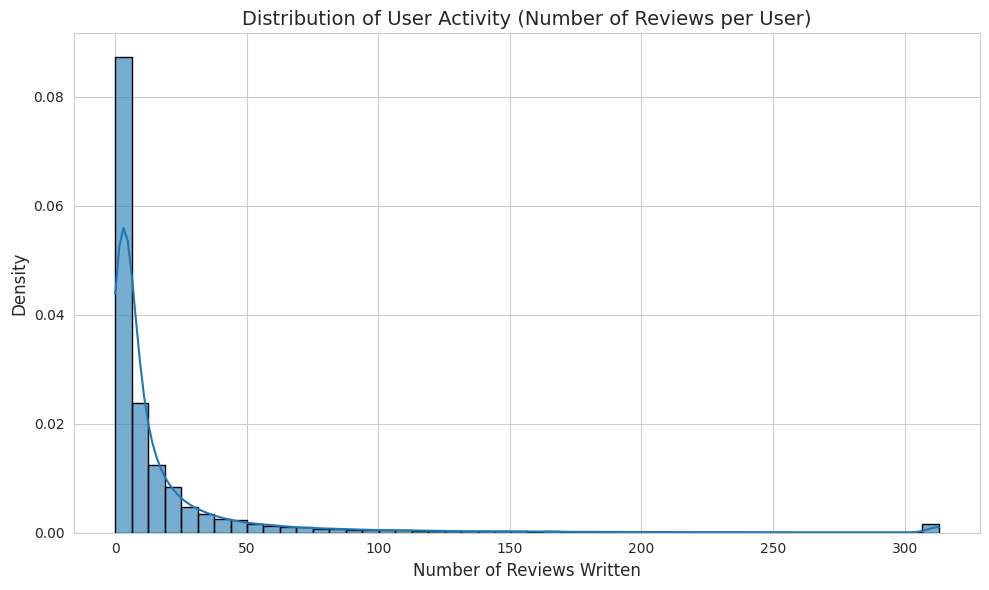

In [34]:
# Scenario 7: Distribution Plot - User Activity (Number of Reviews per User)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Take the total number of reviews written by each user
# In Yelp user dataset, this is typically the 'review_count' column
user_reviews = df_user['review_count'].dropna()

print("Number of users:", len(user_reviews))
print("Basic stats for user review counts:")
print(user_reviews.describe())

# 2. (Optional but recommended) Clip very large values so the plot is readable
# Most users have few reviews, a few have thousands; clipping helps see the bulk.
max_reviews_for_plot = np.percentile(user_reviews, 99)  # keep up to 99th percentile
user_reviews_clipped = user_reviews.clip(upper=max_reviews_for_plot)

print(f"\nClipping values above the 99th percentile (~{max_reviews_for_plot:.0f}) for visualization.")

# 3. Plot histogram + density curve (modern replacement for distplot)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(
    user_reviews_clipped,
    bins=50,
    kde=True,
    stat='density',   # density so histogram and kde are on same scale
    color='tab:blue',
    edgecolor='black',
    alpha=0.6
)

plt.title('Distribution of User Activity (Number of Reviews per User)', fontsize=14)
plt.xlabel('Number of Reviews Written', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

# Scenario 8

Number of businesses with star ratings: 75338
Star rating summary:
count    75338.000000
mean         3.597441
std          0.973815
min          1.000000
25%          3.000000
50%          3.500000
75%          4.500000
max          5.000000
Name: stars, dtype: float64


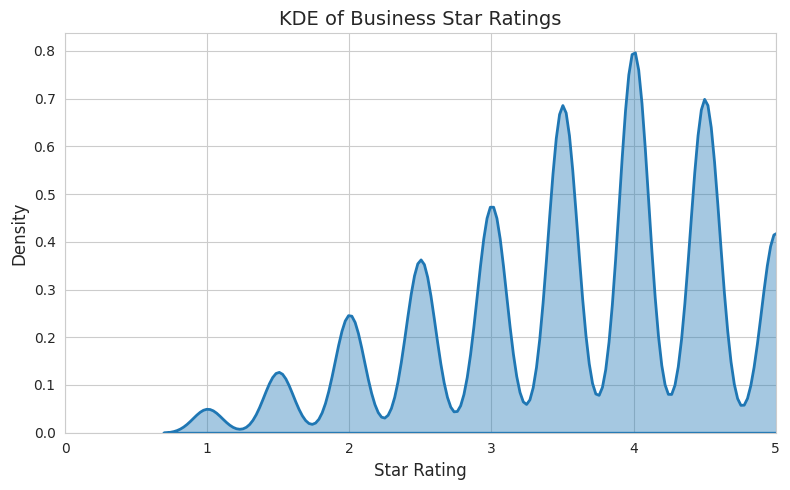

In [35]:
# Scenario 8: KDE Plot - Density of Business Star Ratings

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Take the star ratings of all businesses
business_stars = df_business['stars'].dropna()

print("Number of businesses with star ratings:", len(business_stars))
print("Star rating summary:")
print(business_stars.describe())

# 2. Plot KDE (kernel density estimate) of star distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=business_stars,
    fill=True,        # filled area under the curve
    color='tab:blue',
    alpha=0.4,
    linewidth=2
)

plt.title('KDE of Business Star Ratings', fontsize=14)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.xlim(0, 5)  # ratings are between 0 and 5
plt.tight_layout()
plt.show()

# Scenario 9

Counts per business type used for swarmplot:
biz_type
Restaurant    26163
Shopping      11853
Hotel          2716
Name: count, dtype: int64

Subsampled to 5000 points for clearer visualization.


/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 83.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 65.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 87.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 73.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


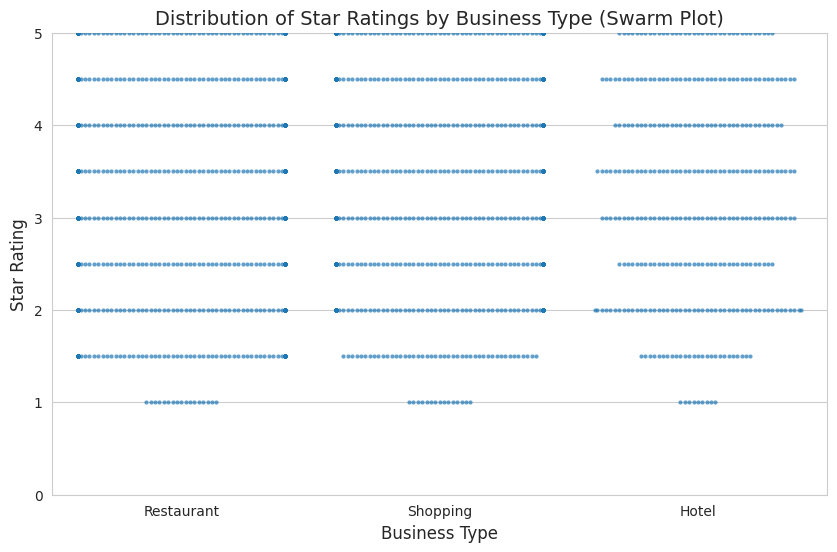

In [36]:
# Scenario 9: Swarm Plot - Distribution of Star Ratings by Business Category

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Work on a copy to avoid SettingWithCopy warnings
df_biz = df_business.dropna(subset=['categories', 'stars']).copy()

# 2. Detect broad business categories: Restaurant, Shopping, Hotel
def detect_biz_type(categories_str):
    c = categories_str.lower()
    if 'restaurants' in c:
        return 'Restaurant'
    if 'shopping' in c:
        return 'Shopping'
    if 'hotels' in c or 'hotel' in c:
        return 'Hotel'
    return None

df_biz['biz_type'] = df_biz['categories'].apply(detect_biz_type)

# 3. Keep only the three types of interest
types_of_interest = ['Restaurant', 'Shopping', 'Hotel']
df_swarm = df_biz[df_biz['biz_type'].isin(types_of_interest)].copy()

print("Counts per business type used for swarmplot:")
print(df_swarm['biz_type'].value_counts())

if df_swarm.empty:
    print("No businesses found for Restaurant / Shopping / Hotel categories.")
else:
    # (Optional) to keep the plot readable, subsample if there are too many points
    max_points = 5000
    if len(df_swarm) > max_points:
        df_swarm = df_swarm.sample(max_points, random_state=42)
        print(f"\nSubsampled to {max_points} points for clearer visualization.")

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    sns.swarmplot(
        data=df_swarm,
        x='biz_type',
        y='stars',
        size=3,
        alpha=0.7
    )

    plt.title('Distribution of Star Ratings by Business Type (Swarm Plot)', fontsize=14)
    plt.xlabel('Business Type', fontsize=12)
    plt.ylabel('Star Rating', fontsize=12)

    plt.ylim(0, 5)  # ratings range 0–5
    plt.show()

# Scenario 10

In [39]:
# Find cities that have stars AND postal_code
df_city_base = df_business.dropna(subset=['city', 'postal_code', 'stars']).copy()

print("Total rows with city, postal_code, and stars:", len(df_city_base))
print("\nTop cities by count (with postal_code present):")
print(df_city_base['city'].value_counts().head(15))

Total rows with city, postal_code, and stars: 75338

Top cities by count (with postal_code present):
city
Philadelphia        7227
Tucson              4647
Tampa               4579
Indianapolis        3749
Nashville           3580
New Orleans         3096
Reno                2933
Edmonton            2539
Saint Louis         2390
Santa Barbara       1860
Boise               1530
Clearwater          1122
Saint Petersburg     862
Metairie             842
Sparks               823
Name: count, dtype: int64


Number of businesses in Philadelphia with postal code and stars: 7227
Number of postal codes kept (>= 30 businesses): 41
Top few postal codes (all):
 postal_code
19103    669
19107    645
19147    634
19106    434
19104    398
Name: count, dtype: int64


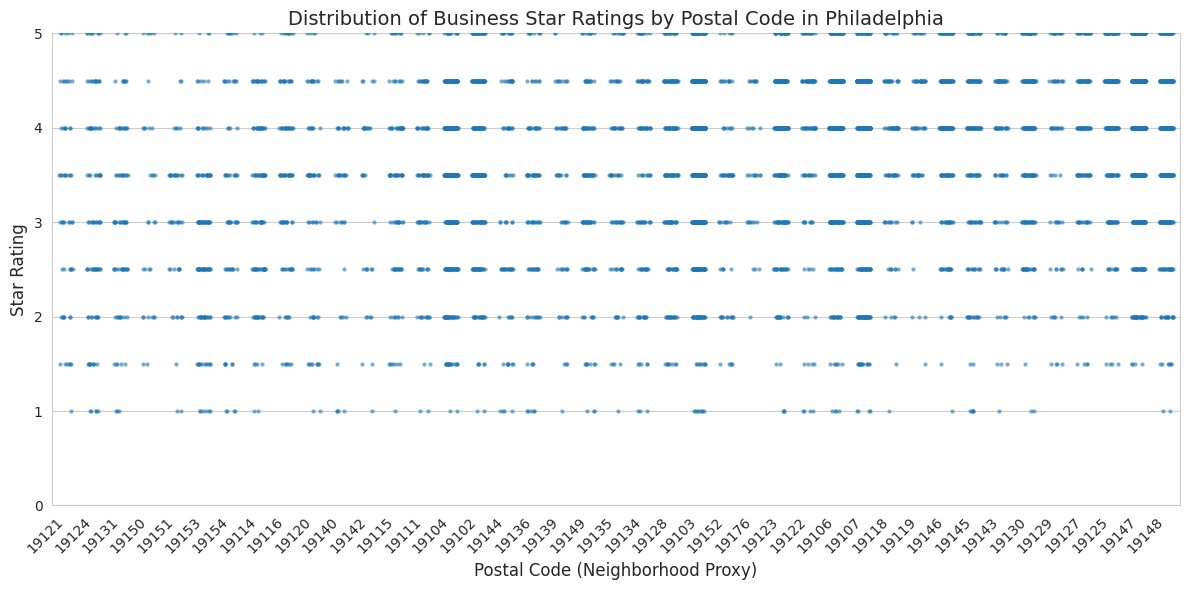

In [40]:
# Scenario 10: Strip Plot - Distribution of Star Ratings Across Neighborhoods in a City

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Choose a major city that actually has postal codes in this sample
city_of_interest = 'Philadelphia'   # you can switch to 'Tucson', 'Tampa', etc. if you prefer

df_city = df_business.dropna(subset=['city', 'postal_code', 'stars']).copy()
df_city = df_city[df_city['city'] == city_of_interest]

print(f"Number of businesses in {city_of_interest} with postal code and stars:", len(df_city))

if df_city.empty:
    print(f"No data for city: {city_of_interest}")
else:
    # 2. Use postal codes as neighborhood proxy; keep only frequent ones for readability
    counts_by_zip = df_city['postal_code'].value_counts()
    min_per_zip = 30  # adjust if needed
    zips_to_keep = counts_by_zip[counts_by_zip >= min_per_zip].index

    df_city_neigh = df_city[df_city['postal_code'].isin(zips_to_keep)].copy()
    print(f"Number of postal codes kept (>= {min_per_zip} businesses):", len(zips_to_keep))
    print("Top few postal codes (all):\n", counts_by_zip.head())

    if df_city_neigh.empty:
        print("After filtering, no postal code has enough businesses. Try lowering min_per_zip.")
    else:
        # Optional: sort postal codes by median stars for nicer ordering
        zip_order = (
            df_city_neigh
            .groupby('postal_code')['stars']
            .median()
            .sort_values()
            .index
        )

        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 6))

        sns.stripplot(
            data=df_city_neigh,
            x='postal_code',
            y='stars',
            order=zip_order,
            jitter=0.25,   # horizontal jitter to avoid overlap
            size=3,
            alpha=0.6
        )

        plt.title(f'Distribution of Business Star Ratings by Postal Code in {city_of_interest}',
                  fontsize=14)
        plt.xlabel('Postal Code (Neighborhood Proxy)', fontsize=12)
        plt.ylabel('Star Rating', fontsize=12)

        plt.ylim(0, 5)
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

# Scenario 11

Counts per business category used for boxplot:
biz_cat
Restaurant       26163
Shopping         11853
Beauty & Spas     6175
Hotel             2716
Name: count, dtype: int64


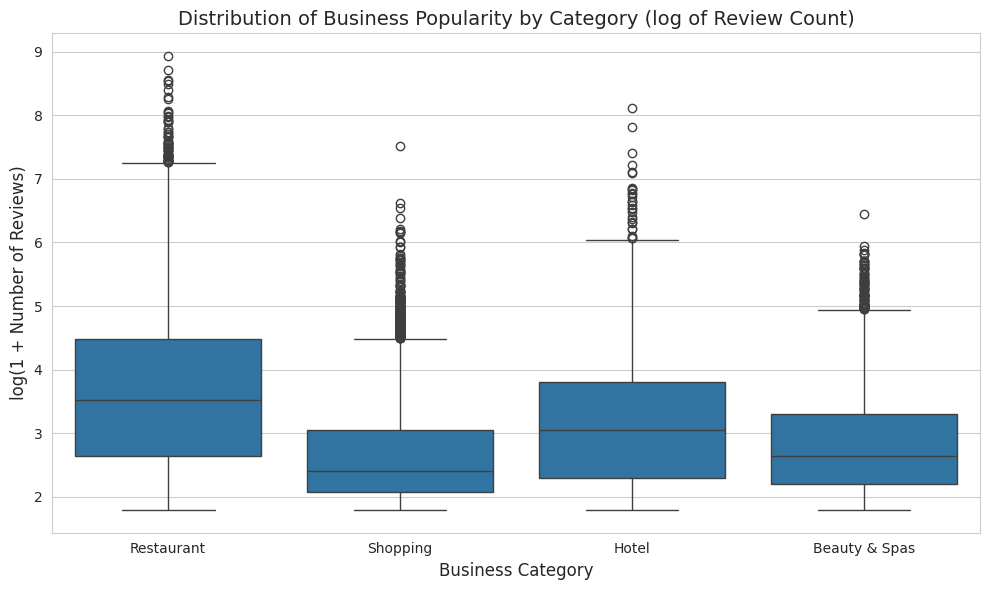

In [41]:
# Scenario 11: Box Plot - Distribution of Popularity (Review Count) by Business Category

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Start from businesses with categories and review_count
df_biz = df_business.dropna(subset=['categories', 'review_count']).copy()

# 2. Detect broad business categories
def detect_biz_category(categories_str):
    c = categories_str.lower()
    if 'restaurants' in c:
        return 'Restaurant'
    if 'shopping' in c:
        return 'Shopping'
    if 'hotels' in c or 'hotel' in c:
        return 'Hotel'
    if 'beauty & spas' in c or 'beauty and spas' in c or 'beauty' in c:
        return 'Beauty & Spas'
    return None

df_biz['biz_cat'] = df_biz['categories'].apply(detect_biz_category)

# 3. Keep only the four categories of interest
cats_of_interest = ['Restaurant', 'Shopping', 'Hotel', 'Beauty & Spas']
df_box = df_biz[df_biz['biz_cat'].isin(cats_of_interest)].copy()

print("Counts per business category used for boxplot:")
print(df_box['biz_cat'].value_counts())

if df_box.empty:
    print("No data for the selected business categories.")
else:
    # Optional: log-transform review_count to make heavy tail more readable
    df_box['review_count_log1p'] = np.log1p(df_box['review_count'])

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    sns.boxplot(
        data=df_box,
        x='biz_cat',
        y='review_count_log1p'  # log(1 + review_count)
    )

    plt.title('Distribution of Business Popularity by Category (log of Review Count)', fontsize=14)
    plt.xlabel('Business Category', fontsize=12)
    plt.ylabel('log(1 + Number of Reviews)', fontsize=12)

    plt.tight_layout()
    plt.show()

Text(0, 0.5, 'Number of Reviews')

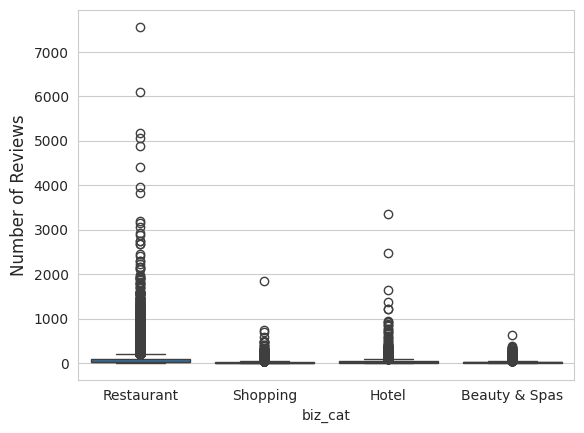

In [42]:
sns.boxplot(
    data=df_box,
    x='biz_cat',
    y='review_count'
)

plt.ylabel('Number of Reviews', fontsize=12)

# Scenario 12

Number of users used in pairplot: 198597
Summary of selected columns:
        review_count         useful           fans  average_stars
count  198597.000000  198597.000000  198597.000000  198597.000000
mean       23.233619      41.269566       1.487465       3.630243
std        80.579053     475.074143      31.706400       1.182755
min         0.000000       0.000000       0.000000       1.000000
25%         2.000000       0.000000       0.000000       3.000000
50%         5.000000       3.000000       0.000000       3.880000
75%        16.000000      13.000000       0.000000       4.560000
max      9941.000000   49385.000000   12497.000000       5.000000


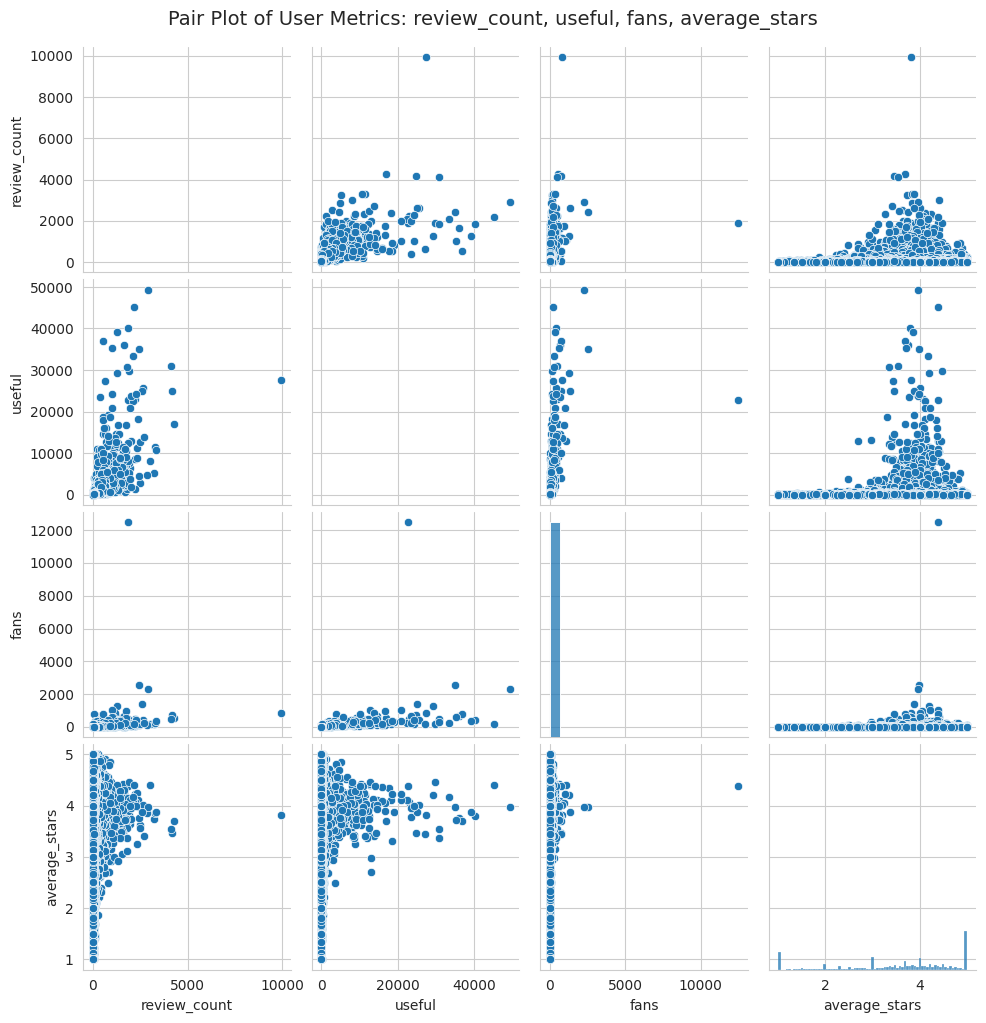

In [43]:
# Scenario 12: Pair Plot - Relationships Between User Variables

import seaborn as sns
import matplotlib.pyplot as plt

# 1. انتخاب ۴ متغیر عددی کاربران
cols = ['review_count', 'useful', 'fans', 'average_stars']

# 2. حذف ردیف‌هایی که در این ستون‌ها مقدار NaN دارند
df_user_num = df_user.dropna(subset=cols).copy()

print("Number of users used in pairplot:", len(df_user_num))
print("Summary of selected columns:")
print(df_user_num[cols].describe())

# 3. رسم pairplot
sns.set_style("whitegrid")

g = sns.pairplot(
    df_user_num[cols],
    diag_kind='hist',   # روی قطر هیستوگرام
    corner=False        # ماتریس کامل 4x4
)

g.fig.suptitle(
    "Pair Plot of User Metrics: review_count, useful, fans, average_stars",
    y=1.02,
    fontsize=14
)

plt.show()

# Scenario 13

Number of businesses with review_count and stars: 75338
       review_count         stars
count  75338.000000  75338.000000
mean      44.359075      3.597441
std      118.278143      0.973815
min        5.000000      1.000000
25%        8.000000      3.000000
50%       15.000000      3.500000
75%       37.000000      4.500000
max     7568.000000      5.000000


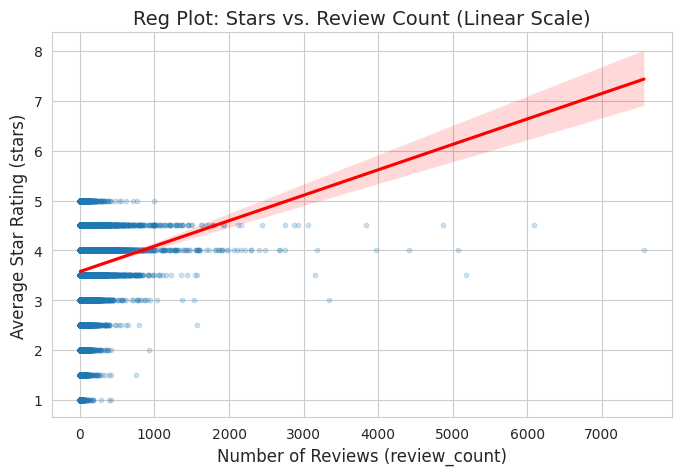

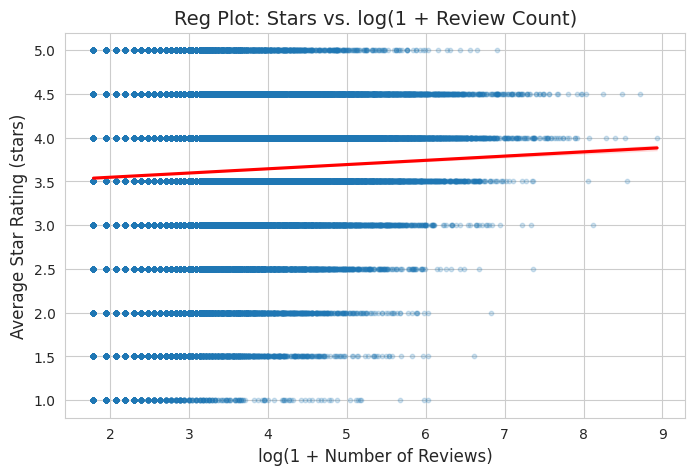

In [44]:
# Scenario 13: Reg Plot - Linear Relationship Between Popularity (review_count) and Quality (stars)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. انتخاب ستون‌ها و حذف مقادیر گمشده
df_biz_reg = df_business.dropna(subset=['review_count', 'stars']).copy()

print("Number of businesses with review_count and stars:", len(df_biz_reg))
print(df_biz_reg[['review_count', 'stars']].describe())

sns.set_style("whitegrid")

# --- نسخه ۱: رابطه مستقیم روی مقیاس خطی ---
plt.figure(figsize=(8, 5))

sns.regplot(
    data=df_biz_reg,
    x='review_count',
    y='stars',
    scatter_kws={'alpha': 0.2, 's': 10},
    line_kws={'color': 'red'}
)

plt.title('Reg Plot: Stars vs. Review Count (Linear Scale)', fontsize=14)
plt.xlabel('Number of Reviews (review_count)', fontsize=12)
plt.ylabel('Average Star Rating (stars)', fontsize=12)

plt.show()

# --- نسخه ۲: رابطه روی مقیاس log(1 + review_count) برای دیدن بهتر majority ---
df_biz_reg['review_count_log1p'] = np.log1p(df_biz_reg['review_count'])

plt.figure(figsize=(8, 5))

sns.regplot(
    data=df_biz_reg,
    x='review_count_log1p',
    y='stars',
    scatter_kws={'alpha': 0.2, 's': 10},
    line_kws={'color': 'red'}
)

plt.title('Reg Plot: Stars vs. log(1 + Review Count)', fontsize=14)
plt.xlabel('log(1 + Number of Reviews)', fontsize=12)
plt.ylabel('Average Star Rating (stars)', fontsize=12)

plt.show()

# Scenario 14

Number of businesses with review_count and stars: 75338
       review_count         stars
count  75338.000000  75338.000000
mean      44.359075      3.597441
std      118.278143      0.973815
min        5.000000      1.000000
25%        8.000000      3.000000
50%       15.000000      3.500000
75%       37.000000      4.500000
max     7568.000000      5.000000


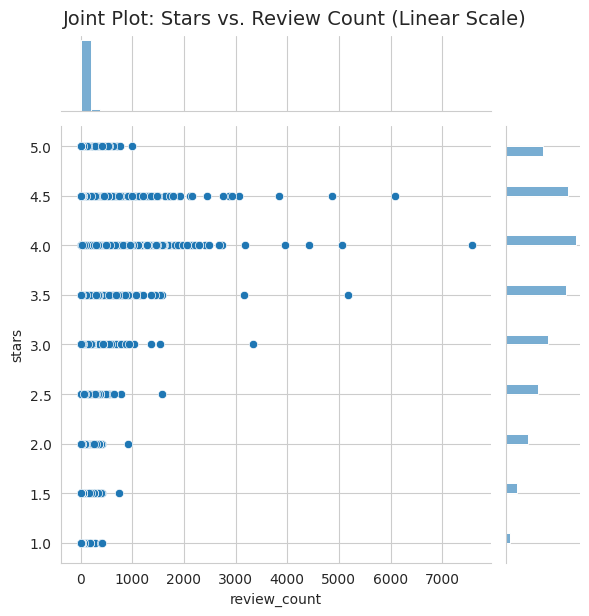

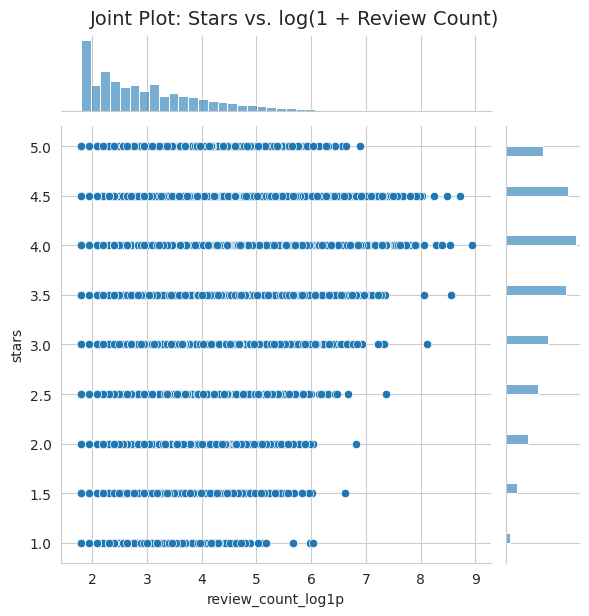

In [45]:
# Scenario 14: Joint Plot - Relationship Between Popularity (review_count) and Quality (stars)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. انتخاب داده‌ها و حذف مقادیر گمشده
df_biz_joint = df_business.dropna(subset=['review_count', 'stars']).copy()

print("Number of businesses with review_count and stars:", len(df_biz_joint))
print(df_biz_joint[['review_count', 'stars']].describe())

sns.set_style("whitegrid")

# --- نسخه ۱: مقیاس خطی ساده (همان چیزی که سناریو می‌خواهد) ---
g = sns.jointplot(
    data=df_biz_joint,
    x='review_count',
    y='stars',
    kind='scatter',            # scatter در مرکز + histogramهای حاشیه‌ای
    height=6,
    space=0.2,                 # فاصله بین نمودار مرکزی و حاشیه‌ها
    marginal_kws={'bins': 40, 'fill': True, 'alpha': 0.6}
)

g.fig.suptitle(
    "Joint Plot: Stars vs. Review Count (Linear Scale)",
    y=1.02,
    fontsize=14
)

plt.show()

# --- نسخه ۲ (اختیاری): مقیاس log برای review_count جهت دیدن بهتر اکثر نقاط ---
df_biz_joint['review_count_log1p'] = np.log1p(df_biz_joint['review_count'])

g2 = sns.jointplot(
    data=df_biz_joint,
    x='review_count_log1p',
    y='stars',
    kind='scatter',
    height=6,
    space=0.2,
    marginal_kws={'bins': 40, 'fill': True, 'alpha': 0.6}
)

g2.fig.suptitle(
    "Joint Plot: Stars vs. log(1 + Review Count)",
    y=1.02,
    fontsize=14
)

plt.show()

# Scenario 15

Number of users used in correlation heatmap: 198597
Summary of selected columns:
        review_count         useful          funny           cool  \
count  198597.000000  198597.000000  198597.000000  198597.000000   
mean       23.233619      41.269566      16.566187      23.089745   
std        80.579053     475.074143     293.986515     398.804296   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         5.000000       3.000000       0.000000       0.000000   
75%        16.000000      13.000000       2.000000       3.000000   
max      9941.000000   49385.000000   41461.000000   42310.000000   

                fans  
count  198597.000000  
mean        1.487465  
std        31.706400  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max     12497.000000  

Correlation matrix:
              review_count    useful     funny      cool      fans
re

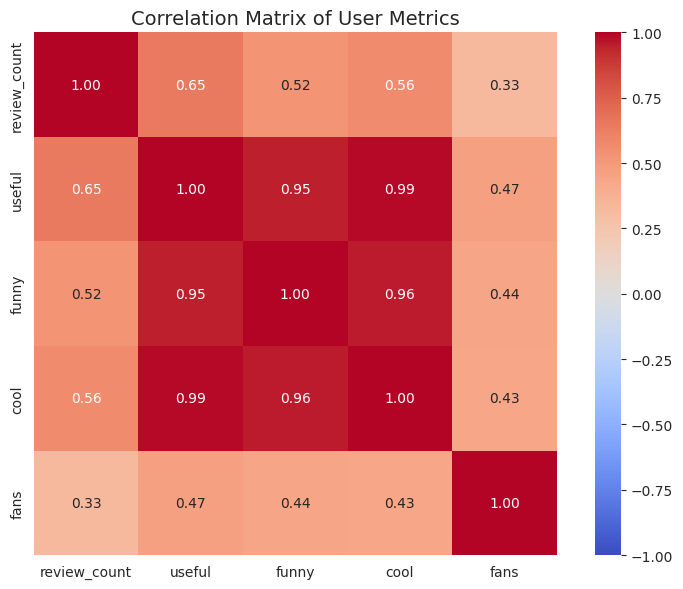

In [46]:
# Scenario 15: Heat Map - Correlation Matrix of User Variables

import seaborn as sns
import matplotlib.pyplot as plt

# 1. انتخاب ۵ متغیر عددی کاربران
cols = ['review_count', 'useful', 'funny', 'cool', 'fans']

# 2. حذف ردیف‌هایی که در این ستون‌ها مقدار NaN دارند
df_user_corr = df_user.dropna(subset=cols).copy()

print("Number of users used in correlation heatmap:", len(df_user_corr))
print("Summary of selected columns:")
print(df_user_corr[cols].describe())

# 3. محاسبه ماتریس همبستگی
corr_matrix = df_user_corr[cols].corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# 4. رسم heatmap
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=True,        # نمایش عدد همبستگی روی هر خانه
    fmt=".2f",
    cmap='coolwarm',   # آبی (منفی) تا قرمز (مثبت)
    vmin=-1, vmax=1,   # محدوده همبستگی -1 تا 1
    square=True
)

plt.title('Correlation Matrix of User Metrics', fontsize=14)
plt.tight_layout()
plt.show()